# **Image Classification of Caltech101 Dataset( Histogram Data )**
Caltech-101 contains a total of 9,146 images, split between 101 distinct object categories (faces, watches, ants, pianos, etc.) and a background category. 

### **Dataset Distribution**

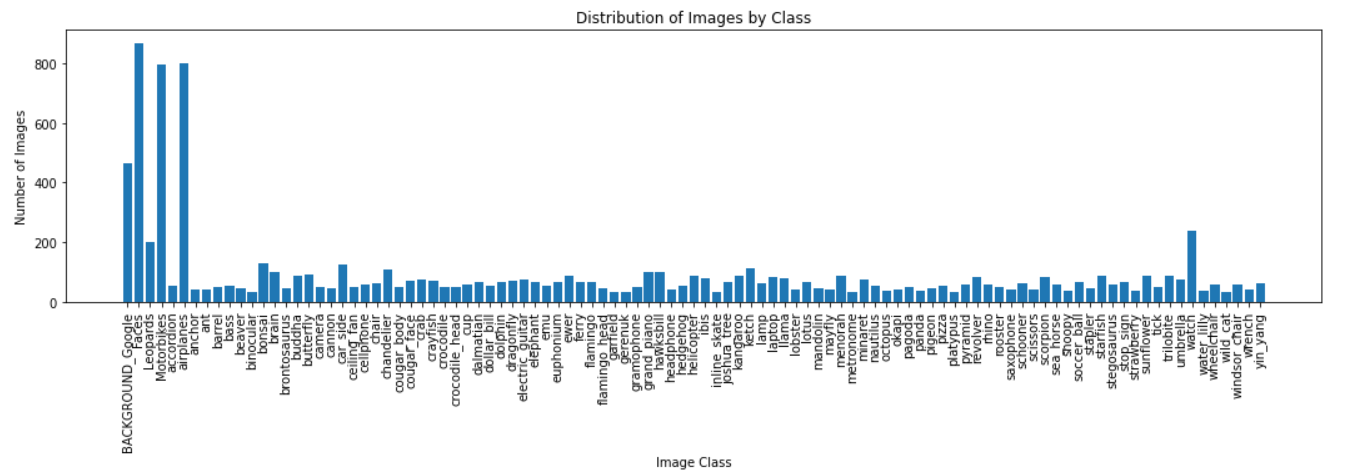

We can clearly see that Faces category has the highest number of images as 870. And the lowest number of images as low as 31. Such an imbalanced dataset is one of the major reasons for the bad performance of deep neural networks and other general classifiers.

### **Run Strategies:**
**`Options`**
1. `Run Classifiers with K-fold Strategy(Training|Testing).`
2. `Run Classifiers with Stratified K-fold Strategy(Training|Testing).` 
3. `Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training.`

for the options 1 and 2, below classifiers used and performance is observed:
1. `Multi-layer Perceptron (MLP) Classifier.`
2. `SVM Classifier.`
3. `Random Forest Classifier.`
4. `KNN Classifier.`
5. `Logistic Regression Classifier.`
6. `LightGBM Classifier.`

Each run is supported with finding the top 3 missclassified classes and classification report.
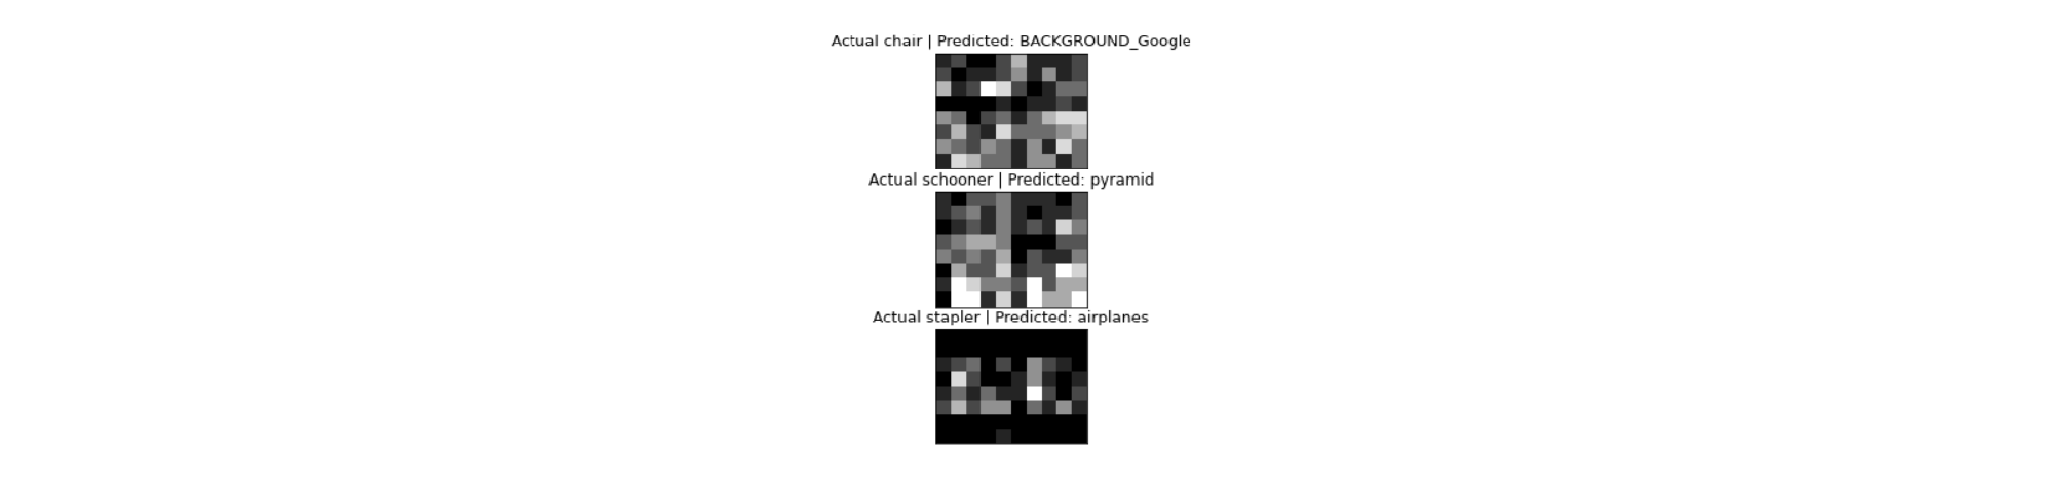

Classifier parameters are tuned using GridSearchCV and AutoML.

**Dataset consideration**
1. **Original Dataset**

Some Observations

`Option 1:`
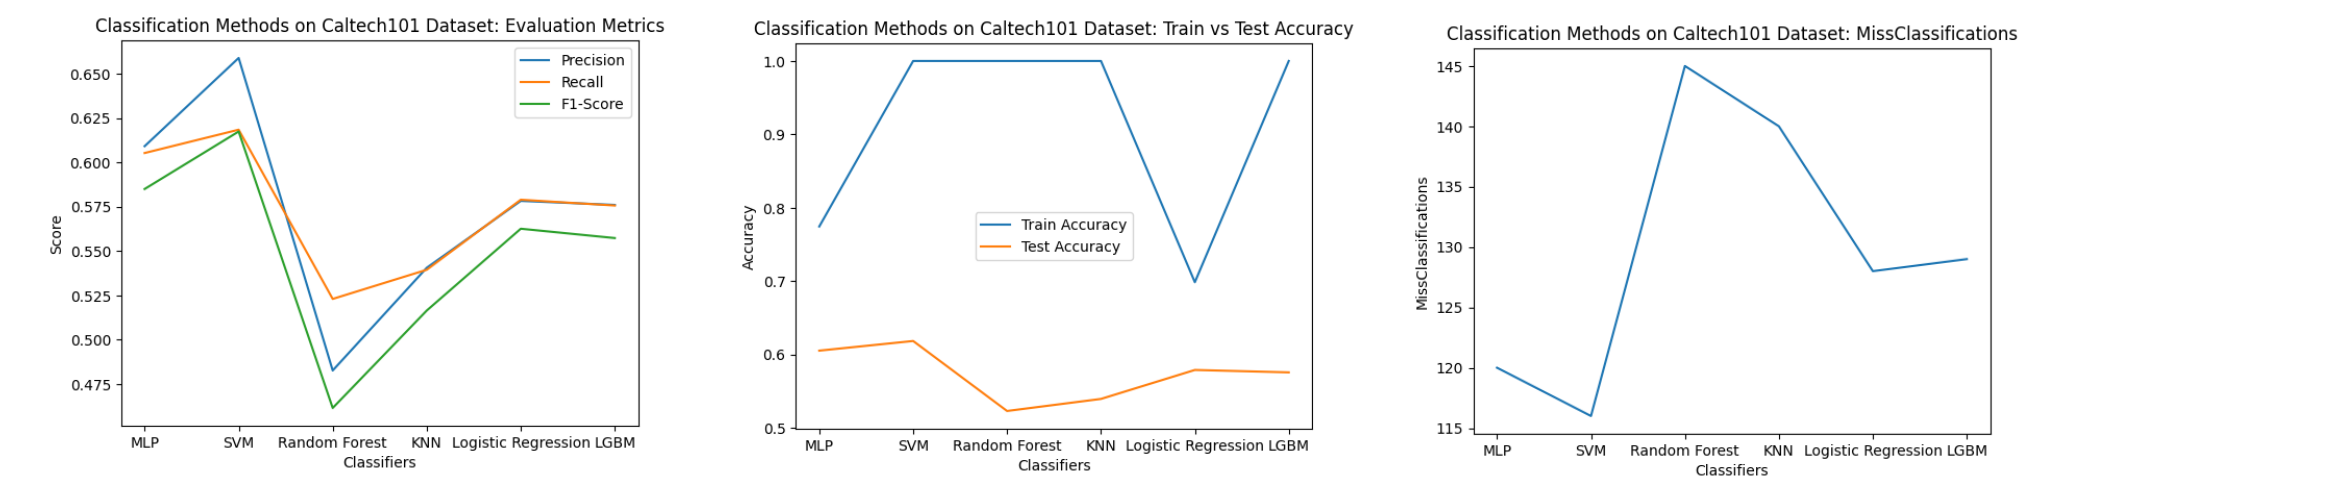
`Option 2:`
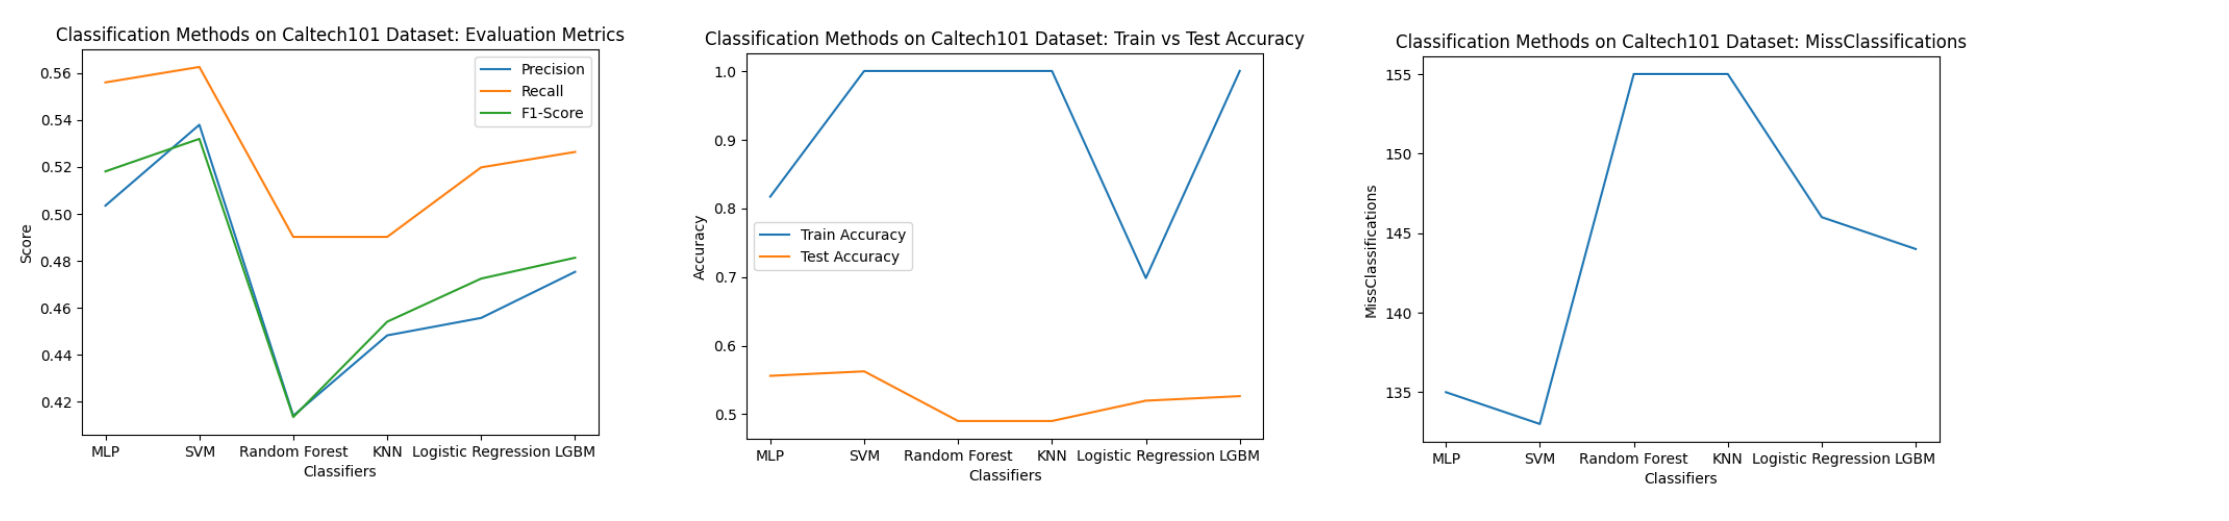
`Option 3:`
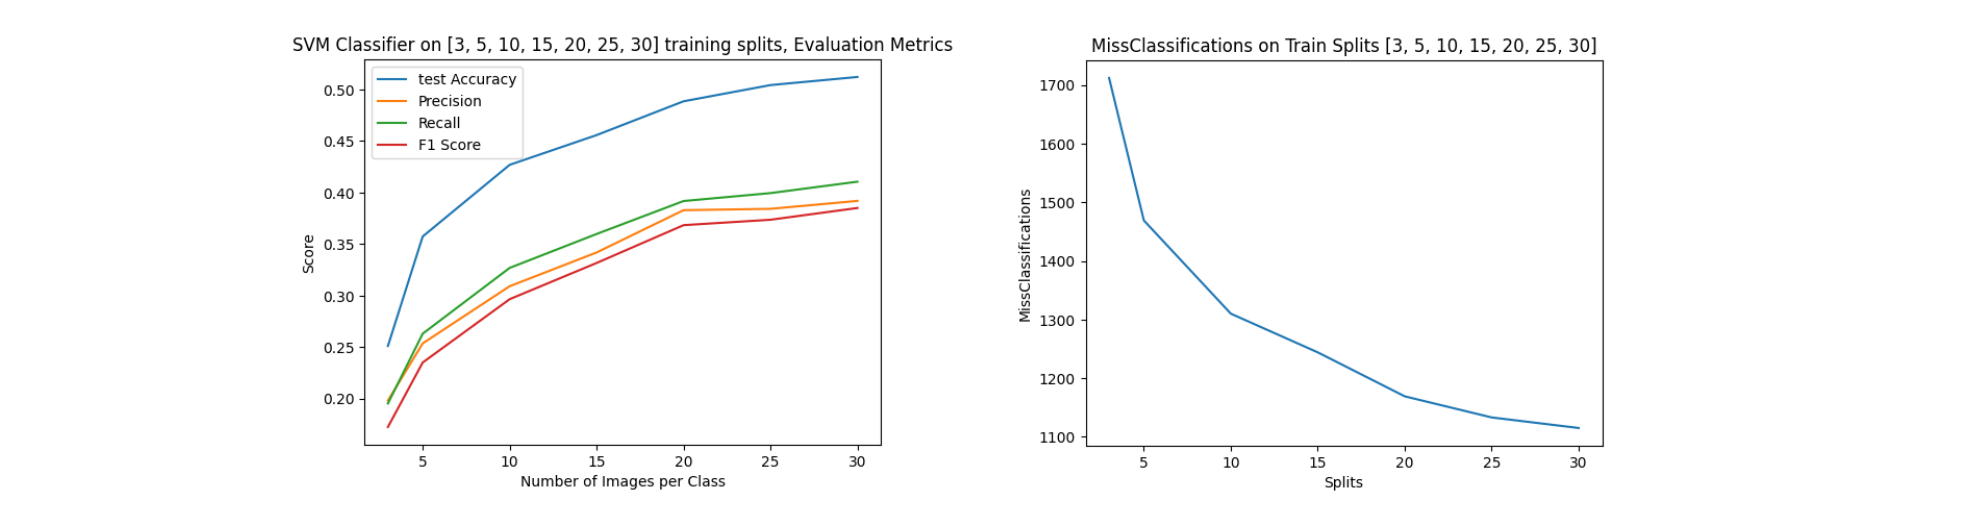

2. **Dataset after Removing the `BACKGROUND_Google` Class.**(noise class).

If we ignore the BACKGROUND_Google label and its images, then we have 8677 images in total. Now, these are not enough images to get very high accuracy, but it increases the accuracy slightly.

Some Observations

`Option 1:`
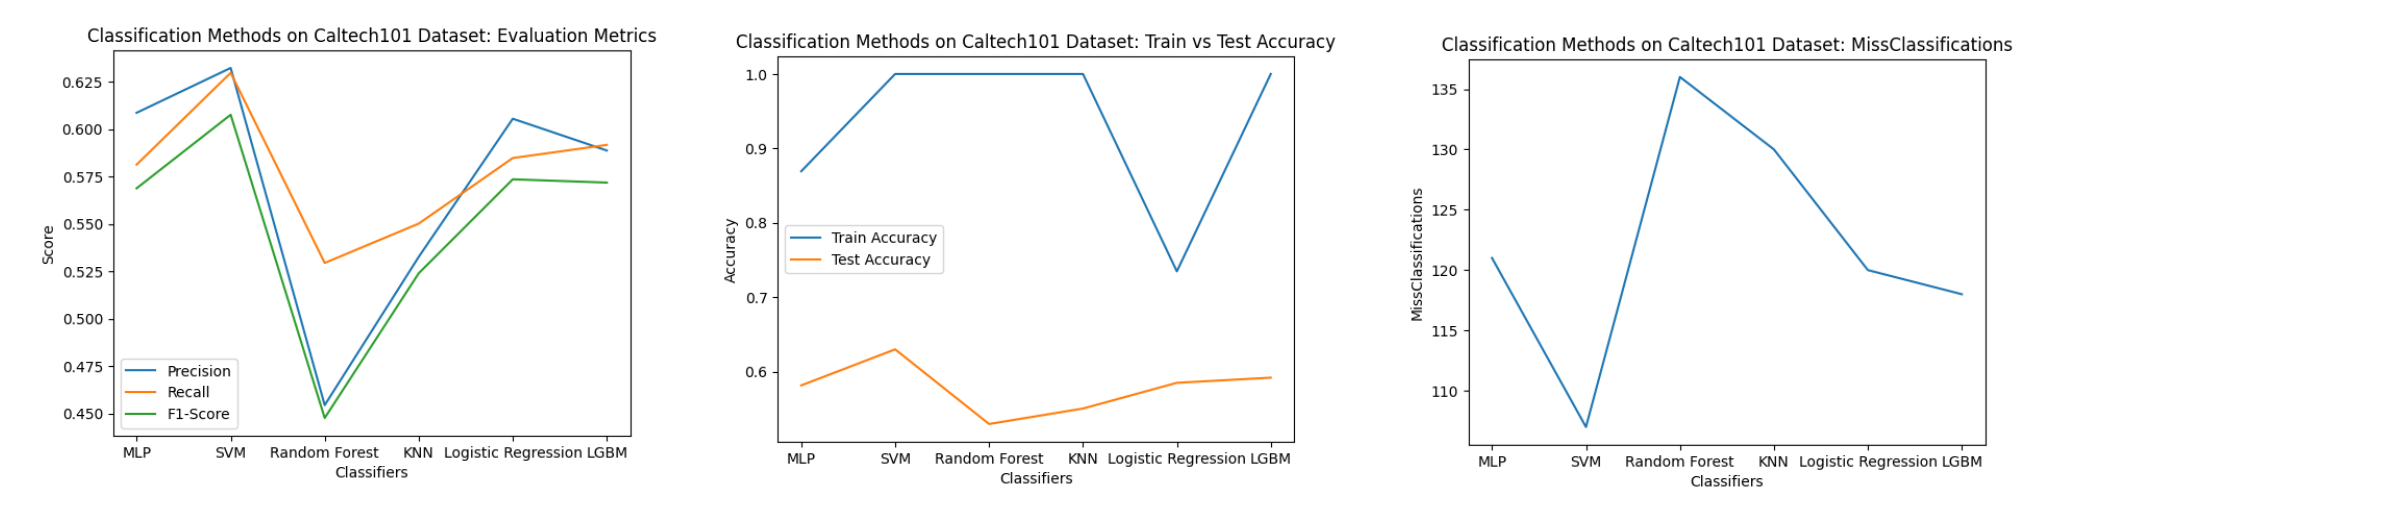
`Option 2:`
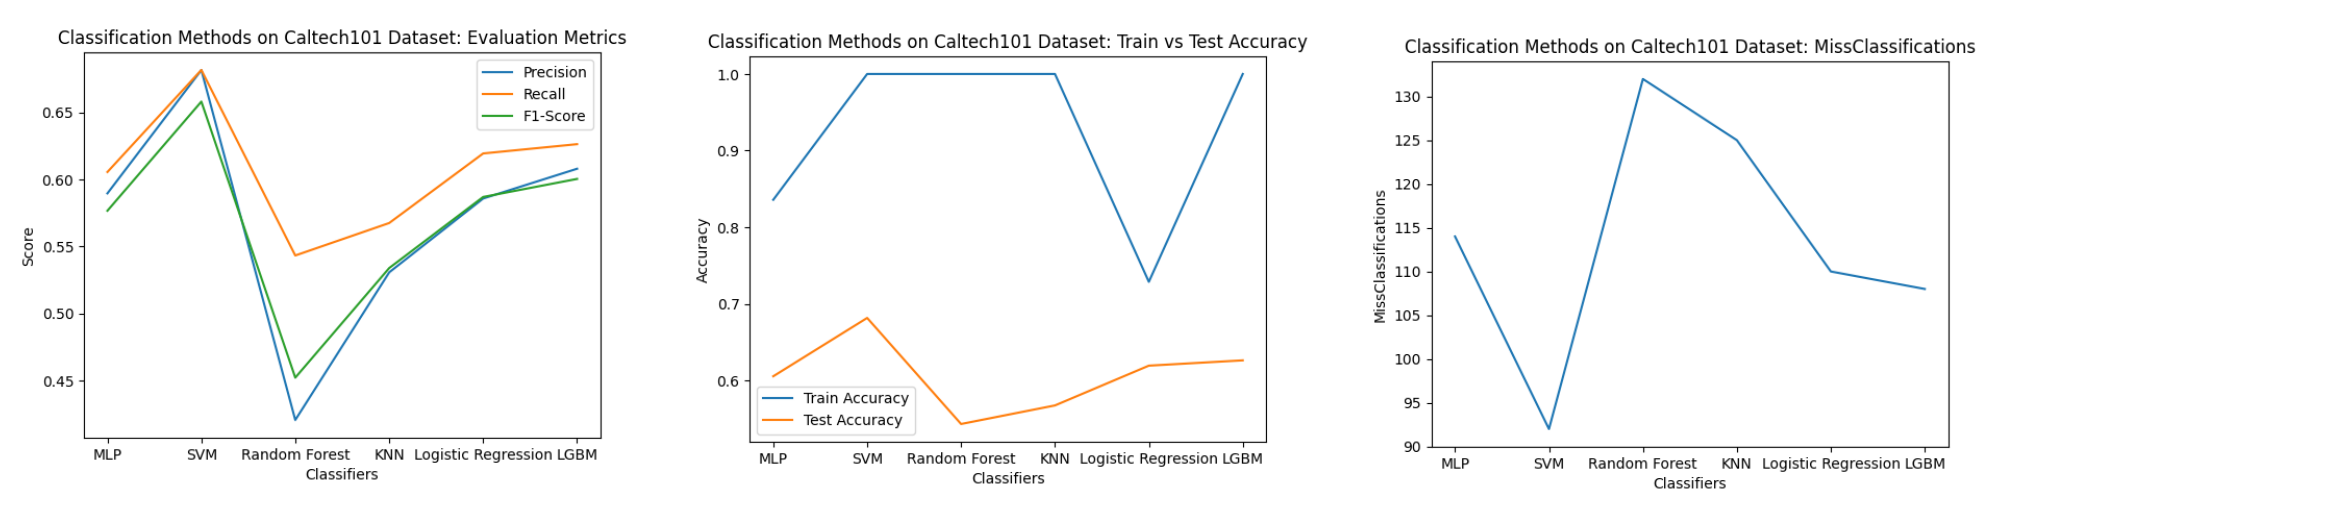
`Option 3:`
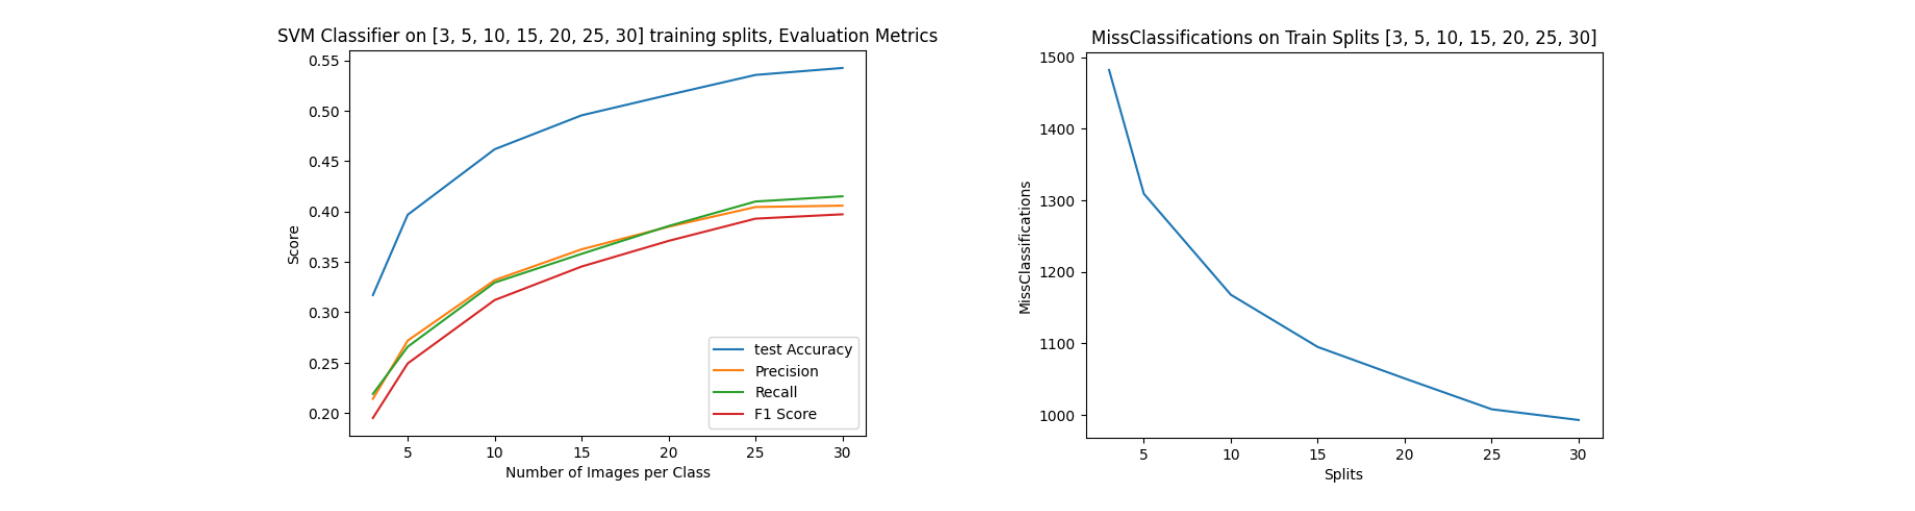

**`From above observations, removing the noise class is improving the classifier performance.`**<br>

**Some general Observation**
1. Training|Testing Strategy have high impact in classifier performance.
2. `random_state` has considerable impact in classifier performance.
3. `[3, 5, 10, 15, 20, 25, 30..]` images per class for training showing increase in accuracy but after the training split `30` classifier seems to get overfitted and accuracy flatlines. This is due to the imbalanced dataset and in the frequency plot we can see minimum number of images in a class is 31 and max is 870, which will impact the classifier performance considerably.
4. SVM classifier is showing good promise in terms of computational cost and accuracy => Reason for choosing SVM over other for train split scenario.

In [390]:
import os
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import csv
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import time
from sklearn import svm
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from flaml import AutoML

In [347]:
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores,images_per_class= [], [], [], [], [], [], [], [],[3,5,10,15,20,25,30]

In [348]:
# Label Extraction
with open('Images.csv', 'r') as f:
    # Read the first line of the file to get the number of images | Firstline Escaper
    num_images = int(f.readline())
    # Initialize lists to store the image IDs and classes
    image_ids = []
    image_classes = []
    # Create a csv reader
    reader = csv.reader(f, delimiter=';')
    # Iterate through each row
    for row in reader:
        # The first column is the image ID
        image_ids.append(row[0])
        # The second column is the class
        image_classes.append(row[1])

In [349]:
# Histogram Data Extraction
histogramDatas = []
with open('EdgeHistogram.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    # Read the first line of the file to get the edge histograms| Firstline Escaper
    next(reader)
    for row in reader:
        feature_vector = [float(x) for x in row[1:]]
        histogramDatas.append(feature_vector)

# Convert the list of edge histograms to a numpy array
histogramData = np.array(histogramDatas)
image_classes= np.array(image_classes)

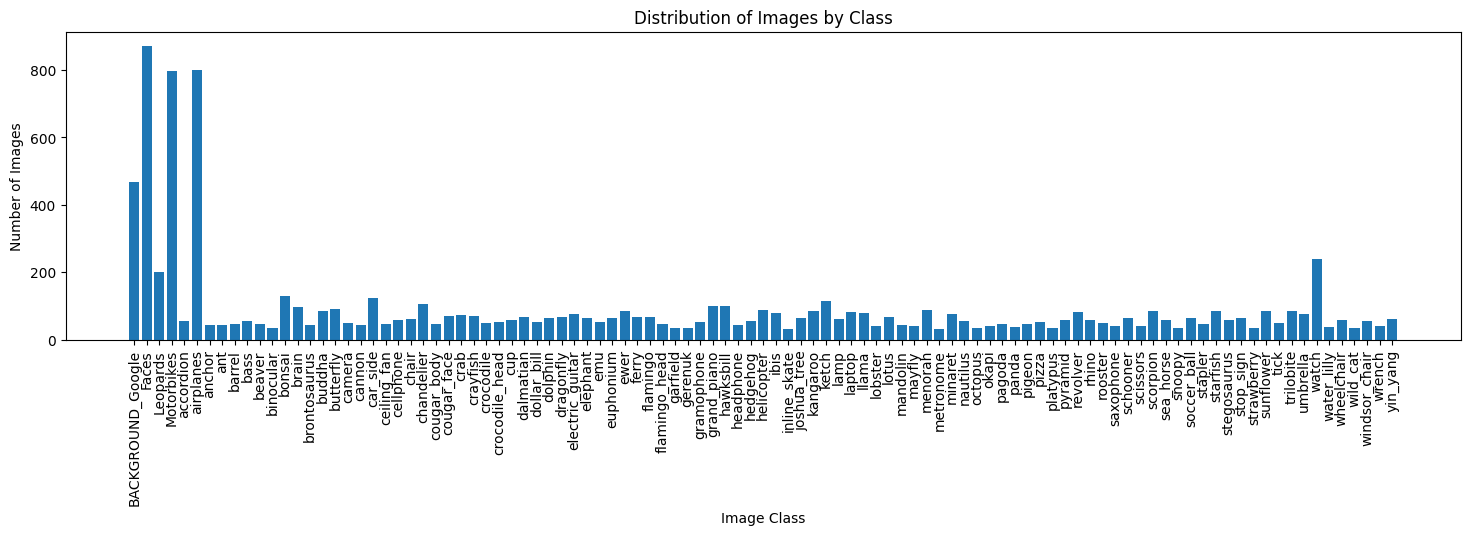

In [350]:
# identifying the class frequency and plotting the same.
unique_labels, counts = np.unique(image_classes, return_counts=True)
fig = plt.figure(figsize=(18,4))
plt.bar(unique_labels, counts)
plt.xlabel('Image Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=90)
plt.yticks()
plt.show()

In [351]:
def edge_histogram_to_image(feature_vector, width, height):
    # Normalize the feature vector between 0 and 255.
    # Dont know how Edge Histogram created in first place so using this right now.
    minVal = min(feature_vector)
    maxVal = max(feature_vector)
    feature_vector = [(x - minVal) / (maxVal - minVal) * 255 for x in feature_vector]
    # Convert the feature vector to a grayscale image
    img = Image.new('L', (width, height))
    img.putdata(feature_vector)
    return img

def plot_sample(x, y, index):
    img = edge_histogram_to_image(x[index], 10, 8)
    plt.figure(figsize = (5,2))
    plt.imshow(img, cmap='gray')
    plt.xlabel(y[index])
    plt.show()

**Function to Calculate Train and test accuracy**

In [352]:
def  acc_find(clf,clfLabel,X_train, X_test, y_train, y_test):
  classifiers.append(clfLabel)
  train_accuracy = clf.score(X_train, y_train)
  train_acc.append(train_accuracy)
  # Compute the accuracy on the validation set
  test_accuracy = clf.score(X_test, y_test)
  test_acc.append(test_accuracy)
  print("Train Accuracy for {} is: {} ".format(clfLabel,train_accuracy))
  print("Test Accuracy for {} is: {}".format(clfLabel,test_accuracy))

**Function to Calculate Precision, Recall, fscore**

In [353]:
def  precision_recall_fscore_find(clf,X_train, X_test, y_train, y_test):
  # Predict the labels of the test data
  y_pred = clf.predict(X_test)

  # Calculate precision, recall, F1-score, and support
  precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  # Print the results
  precisions.append(precision)
  print("Precision:", precision)
  recalls.append(recall)
  print("Recall:", recall)
  f1_scores.append(fscore)
  print("F1-score:", fscore)

**Function to Find the no of Miss Classifications on each classification Method**

In [354]:
def findMissClassification(clf,clfmethod,X_test,y_test):
  classifiersMiss.append(clfmethod)
  pred = clf.predict(X_test)
  num_wrong_cls = np.sum(pred != y_test)
  num_wrong_clss.append(num_wrong_cls)
  print("Number of images incorrectly classified for {} is: {}".format(clfmethod,num_wrong_cls))

**Function to find Top 3 Incorrect Classifications and plotting them**

In [355]:
def incorrect_top_3(clf,X_test, y_test):
  print("Top 3 Miss-Classified Classes.")
  pred = clf.predict(X_test)
  incorrect_pred = pred != y_test
  incorrect_idx = np.where(incorrect_pred == True)
  top_three = incorrect_idx[0][:3]
  plt.figure(figsize = (10, 10))
  for i, idx in enumerate(top_three):
      plt.subplot(5,1,i + 1),plt.imshow(edge_histogram_to_image(X_test[idx],10,8),cmap = 'gray')
      plt.title('Actual {} | Predicted: {}'.format(y_test[idx], pred[idx])), plt.xticks([]), plt.yticks([])
  plt.show()

### **Noise Class removal**

"BACKGROUND_Google" is found to a noise class if need to remove it we can use the below function.

**Note**: Without "BACKGROUND_Google" found an increase in test accuracy and decrease in missclassification count

In [356]:
def class_remove(class_to_remove, image_classes, histogramData):
  # Find the indices of the histograms that belong to the class to be removed
  indices_to_remove = np.where(image_classes == class_to_remove)

  # Remove the histograms and their corresponding labels
  histogramData = np.delete(histogramData, indices_to_remove, axis=0)
  image_classes = np.delete(image_classes, indices_to_remove)
  return histogramData, image_classes
nmrClassess=len(np.unique(image_classes))

### **K-fold cross validation**: 

This method involves dividing the dataset into k subsets, where k-1 subsets are used for training and the remaining subset is used for testing. This method is useful for evaluating the model's performance and identifying overfitting.

In [357]:
def kfoldDivision(splits):
  kf = KFold(n_splits=splits, shuffle=True, random_state=42)
  for train_index, test_index in kf.split(histogramData):
      X_train, X_test = histogramData[train_index], histogramData[test_index]
      y_train, y_test = image_classes[train_index], image_classes[test_index]
  return X_train, X_test, y_train, y_test

### **Stratified k-fold**: 

is a technique for cross-validation in machine learning where the data is divided into k folds, and the folds are created such that each fold contains roughly the same proportions of the different classes in the data. This is used to ensure that each fold is representative of the overall distribution of the data and to prevent any bias in the training or evaluation of the model.

In [358]:
def stratifiedKFoldDivision(splits):
  skf = StratifiedKFold(n_splits=splits,shuffle=True,random_state=18)
  for train_index, test_index in skf.split(histogramData,image_classes):
      X_train, X_test = histogramData[train_index], histogramData[test_index]
      y_train, y_test = image_classes[train_index], image_classes[test_index]
  return X_train, X_test, y_train, y_test

### **ANN Classifier: Multi-layer Perceptron (MLP)**

A Multi-layer Perceptron (MLP) is a type of artificial neural network that is often used for supervised learning tasks such as classification and regression. It consists of multiple layers of interconnected "neurons," which process and transmit information through the network.

An MLP classifier is made up of an input layer, one or more hidden layers, and an output layer. The input layer receives the input features, and each neuron in the hidden and output layers performs a computation on the input and produces an output. The computations involve a set of weights and biases, which are learned during the training process in order to make accurate predictions.

MLP classifiers are particularly useful for problems with complex, non-linear decision boundaries. They are also able to capture interactions between features, and can handle high-dimensional input spaces.

**Note:** loss difference in a machine learning model typically refers to the difference in error or performance between the model's predicted output and the actual output. A lower loss value indicates better performance and a higher loss value indicates worse performance. 

**mlpGridSearch()**

Function to perform hyperparameter tuning.

In [359]:
def MLPClassifierTrial(X_train, X_test, y_train, y_test):
  print("Multi-layer Perceptron Classification.")
  mlp = MLPClassifier(activation='relu', 
                      alpha=1,  
                      random_state=56,
                      hidden_layer_sizes=(80, 120, nmrClassess),
                      max_iter=1000)
  mlp.solver='adam' #change accordingly , 'lbfgs', 'sgd', 'adam'
  mlp.fit(X_train, y_train)
  acc_find(mlp,'MLP',X_train, X_test, y_train, y_test)
  findMissClassification(mlp,'MLP', X_test, y_test)
  precision_recall_fscore_find(mlp,X_train, X_test, y_train, y_test)
  # Compute loss on the training set
  train_loss = mlp.loss_

  # Compute loss on the test set
  labels = np.unique(mlp.predict(X_train))
  test_loss = log_loss(y_test, mlp.predict_proba(X_test), labels=labels)
  print('Loss difference observed Between train/test:',test_loss-train_loss)
  incorrect_top_3(mlp,X_test, y_test)

In [360]:
def mlpGridSearch(X_train, X_test, y_train, y_test):
  print("Multi-layer Perceptron GridSearch Classification.")
  # Define MLP classifier
  mlp = MLPClassifier()
  
  # Define hyperparameters and possible values to tune
  param_grid = {
      'hidden_layer_sizes': [(80,120,nmrClassess), (80,100,nmrClassess), (160,150,nmrClassess)],
      'activation': ['relu', 'tanh', 'logistic'],
      'solver': ['adam'],
      'learning_rate': ['constant', 'invscaling', 'adaptive'],
      'alpha': [0.0001, 0.001, 0.01],
      'learning_rate_init': np.logspace(-5, 0, 5)
  }
  
  # Initialize GridSearchCV with the classifier and hyperparameters
  grid_search = GridSearchCV(mlp, param_grid, cv=5)

  # Fit GridSearchCV on the training data
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  print("Best values:",best_params)

  # Train a MLP classifier with the best hyperparameters on the entire training data
  best_mlp = MLPClassifier(**best_params)
  best_mlp.fit(X_train, y_train)

  acc_find(best_mlp,'mlp_Grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_mlp,'mlp_Grid',X_test, y_test)
  precision_recall_fscore_find(best_mlp,X_train, X_test, y_train, y_test)

### **SVM Classification**:

Support Vector Machines (SVMs) are a type of supervised learning algorithm that can be used for classification or regression tasks. The idea behind SVMs is to find the best boundary (or "hyperplane") that separates the different classes in the data.

In a SVM classifier, the algorithm finds the hyperplane that maximizes the margin, which is the distance between the hyperplane and the closest data points from each class. These closest data points are called "support vectors" and have a crucial role in defining the position of the hyperplane.

SVMs have several advantages over other algorithms, such as:

*   They work well with high-dimensional data, and can handle a large number of features.
*   They are effective in cases where the number of features is greater than the number of samples.
*   They can handle non-linearly separable data by transforming the input space into a higher dimensional space where a linear hyperplane can be used to separate the classes.

**svmGridSearch()**

Function to perform hyperparameter tuning to find best param for 'C' and it uses a stratified K-Fold.

**svmTrainingDivision()**

Function to perform training split classifications.


In [361]:
def svmClassifierPlusGridtrial(X_train, X_test, y_train, y_test):
  print("Support Vector Machines (SVMs) Classification.")
  svmClassifier = svm.SVC(kernel='rbf', C=100, shrinking=False, gamma='scale')
  # fit the classifier to the histogram and labels data
  svmClassifier.fit(X_train, y_train)
  findMissClassification(svmClassifier,'SVM', X_test,  y_test)
  acc_find(svmClassifier,'SVM',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(svmClassifier,X_train, X_test, y_train, y_test)
  incorrect_top_3(svmClassifier, X_test, y_test)


In [362]:
def svmGridSearch(X_train, X_test, y_train, y_test):
  # Define the range of values for C to test
  param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'kernel': ['linear', 'rbf'],
                'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
                'shrinking': [True, False]}

  # Define the SVM model
  svms = svm.SVC()

  # Use GridSearchCV to perform k-fold cross-validation with 5 folds
  grid_search = GridSearchCV(svms, param_grid, cv=5,return_train_score=True)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("Best values:",best_params)
  # Train a SVM classifier with the best hyperparameters on the entire training data
  best_svm = svm.SVC(**best_params)
  best_svm.fit(X_train, y_train)

  acc_find(best_svm,'SVM_grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_svm,'SVM_grid',X_test, y_test)
  precision_recall_fscore_find(best_svm,X_train, X_test, y_train, y_test)

In [363]:
def svmTrainingDivision(images_per_class):
    print("--------------------------------------------------------------------")
    print("Support Vector Machines (SVMs) Classification.")
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(histogramData, image_classes, test_size=0.25, random_state=42)

    # Initialize lists to store the results
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    num_wrong = []

    # Loop over the different number of images per class
    for num_images in images_per_class:
        print("************************************************************")
        print("Trial with {} number of images in classes".format(num_images))
        # Split the training set into subsets with the desired number of images per class
        indices = np.array([], dtype=int)
        for label in np.unique(y_train):
          label_indices = np.where(y_train == label)[0]
          indices = np.concatenate((indices, label_indices[:num_images]))
        X_train_subset, y_train_subset = X_train[indices], y_train[indices]
        svmClassifier = svm.SVC(kernel='rbf', C=100, shrinking=False, gamma='scale') 
        svmClassifier.fit(X_train_subset, y_train_subset)
        # Evaluate the model on the test set
        y_pred = svmClassifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        num_wrong_cls = np.sum(y_pred != y_test)
        print("Number of images incorrectly classified for SVM is: {}".format(num_wrong_cls))
        print("Test Accuracy for SVM is: {}".format(accuracy))
        print("Precision for SVM is: {}".format(precision))
        print("Recall for SVM is: {}".format(recall))
        print("F1 Score for SVM is: {}".format(f1))

        # Store the results
        num_wrong.append(num_wrong_cls)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    # Plot the results
    plt.plot(images_per_class, accuracies, label='test Accuracy')
    plt.plot(images_per_class, precisions, label='Precision')
    plt.plot(images_per_class, recalls, label='Recall')
    plt.plot(images_per_class, f1s, label='F1 Score')
    plt.xlabel('Number of Images per Class')
    plt.ylabel('Score')
    plt.legend()
    plt.title('SVM Classifier on {} training splits, Evaluation Metrics'.format(images_per_class))
    plt.show()
    plt.plot(images_per_class, num_wrong, label='Wrong Classifications')
    plt.xlabel('Splits')
    plt.ylabel('MissClassifications')
    plt.title('MissClassifications on Train Splits {}'.format(images_per_class))
    plt.show()

### **RandomForestClassifier**

Random Forest is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

**RandomForestGridSearch()**
Function to perform hyperparameter tuning.

In [364]:
# Train and test Random Forest classifier
def randomForestClassifierTrial(X_train, X_test, y_train, y_test):
  print("Random Forest Classifier.")
  rf = RandomForestClassifier(max_depth=None, n_estimators=500, min_samples_split=2, min_samples_leaf=1, random_state=12)
  rf.fit(X_train, y_train)
  findMissClassification(rf,'Random Forest',X_test,  y_test)
  acc_find(rf,'Random Forest',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(rf,X_train, X_test, y_train, y_test)
  incorrect_top_3(rf, X_test,  y_test)

In [365]:
def RandomForestGridSearch(X_train, X_test, y_train, y_test):
  # Define the grid of hyperparameters to search
  param_grid = {
      'n_estimators': [10, 50, 100, 500],
      'max_depth': [None, 5, 10, 20],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  # Initialize the classifier
  rf = RandomForestClassifier()

  # Use GridSearchCV to find the best hyperparameters
  
  grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  print("Best values:",best_params)

  # Train a RandomForestClassifier classifier with the best hyperparameters on the entire training data
  best_RF = RandomForestClassifier(**best_params)
  best_RF.fit(X_train, y_train)

  acc_find(best_RF,'RF_grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_RF,'RF_grid',X_test, y_test)
  precision_recall_fscore_find(best_RF,X_train, X_test, y_train, y_test)

### **KNN Classifier**

KNN, or k-Nearest Neighbors, is a simple yet powerful classification and regression algorithm. The basic idea behind the KNN algorithm is to find the k-number of closest data points (neighbors) to a given data point, and then predict the class or value of that point based on the majority class or average value of its k-nearest neighbors.

The KNN algorithm is sensitive to the scale of the data.

**KNNGridSearch()**

Function to perform hyperparameter tuning.

In [366]:
# Train and test KNN classifier
def knnClassifierTrial(X_train, X_test, y_train, y_test):
  print("KNN Classifier.")
  knn = KNeighborsClassifier(weights='distance',n_neighbors=5, p=1)
  knn.n_neighbors=1
  knn.fit(X_train, y_train)
  findMissClassification(knn,'KNN', X_test, y_test)
  acc_find(knn,'KNN',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(knn,X_train, X_test, y_train, y_test)
  incorrect_top_3(knn,X_test,  y_test)

In [367]:
def KNNGridSearch(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier()

  # Define the parameter grid
  param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]}

  # Create a GridSearchCV object
  grid_search = GridSearchCV(knn, param_grid, cv=5)

  # Fit the GridSearchCV object to the training data
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best score
  best_params = grid_search.best_params_
  print("Best parameters: ", best_params)

  # Train the KNN classifier with the best parameters on the full training data
  knn = KNeighborsClassifier(**best_params)
  knn.fit(X_train, y_train)


  acc_find(knn,'KNN_grid',X_train, X_test, y_train, y_test)
  findMissClassification(knn,'KNN_grid',X_test, y_test)
  precision_recall_fscore_find(knn,X_train, X_test, y_train, y_test)

### **Logistic Regression Classifier**

Logistic Regression is a popular classification algorithm used for binary and multi-class classification problems. It is a type of generalized linear model (GLM) that uses the logistic function to model the probability of a sample belonging to a particular class.

**LRGridSearch()**

Function to perform hyperparameter tuning.

In [368]:
# Train and test Logistic Regression classifier
def logisticRegressionClassifier(X_train, X_test, y_train, y_test):
  print("Logistic Regression Classifier.")
  lr = LogisticRegression(random_state=0,solver='lbfgs',penalty='l2',C=.1)
  lr.fit(X_train, y_train)
  findMissClassification(lr,'Logistic Regression',X_test,y_test)
  acc_find(lr,'Logistic Regression',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(lr,X_train, X_test, y_train, y_test)
  incorrect_top_3(lr,X_test, y_test)

In [369]:
def LRGridSearch(X_train, X_test, y_train, y_test):
  param_grid = {
      'C': [0.1, 1, 10, 100, 1000],
      'penalty': ['l1', 'l2']
  }

  # Initialize the logistic regression model
  logreg = LogisticRegression()

  # Initialize the grid search
  grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

  # Fit the grid search to the data
  grid_search.fit(X_train, y_train)

  # Print the best parameters and the best score
  best_params=grid_search.best_params_
  print("Best parameters: ", best_params)
  lr=LogisticRegression(**best_params)
  lr.fit(X_train, y_train)


  acc_find(lr,'LR_grid',X_train, X_test, y_train, y_test)
  findMissClassification(lr,'LR_grid',X_test, y_test)
  precision_recall_fscore_find(lr,X_train, X_test, y_train, y_test)

### **LightGBM Classifier**

LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be efficient and scalable, and is well-suited for large-scale multiclass classification problems. 

**lgbmClassifierTuning()**

Function to perform hyperparameter tuning.

In [370]:
# Train and test Logistic Regression classifier
def lgbmClassifier(X_train, X_test, y_train, y_test):
  print("LGBM Classifier.")
  #clf=lgb.LGBMClassifier(learning_rate=.1, max_bin=10,num_classes=101,random_state=42,metric='multi_logloss',boosting_type='gbdt',n_estimators=80,max_iter=300)
  clf=lgb.LGBMClassifier(learning_rate=0.15630705206654863, max_bin=511,
               min_child_samples=59, n_estimators=32, num_leaves=26,
               reg_alpha=0.0009765625, reg_lambda=0.30947036974938247,
               verbose=-1,num_classes=101,max_iter=300)
  clf.fit(X_train,y_train)
  findMissClassification(clf,'LGBM',X_test,y_test)
  acc_find(clf,'LGBM',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(clf,X_train, X_test, y_train, y_test)
  incorrect_top_3(clf,X_test, y_test)

In [371]:
def lgbmClassifierTuning():
    X_train, X_test, y_train, y_test = stratifiedKFoldDivision(30)
    automl = AutoML()
    settings = {
        "time_budget": 100,  # total running time in seconds
        "metric": 'mae',
        "estimator_list": ['lgbm'],
        "task": 'multiclass',  # task type
        "seed": 7654321,  # random seed
    }
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    print(automl.model.estimator)

### **Plotting Functions**
(for some necessary repeated ploting requirements)
1.   plotClassificationmethodsVSEvalutionMetrics
2.   plotClassifierVSTrainTestAccuracy
3.   plotMissClassificationReport
4.   plotSplitmetrics






In [372]:
def filterValue(array1,array2):
  # Create a dictionary with unique values in array2 as keys
  filtered_elements = {val: [] for i, val in enumerate(array2) if array2.index(val) == i}

  # Filter array1 based on each value in array2
  for i in range(len(array1)):
      filtered_elements[array2[i]].append(array1[i])

  # Print the filtered elements
  return filtered_elements;

In [373]:
def plotClassificationmethodsVSEvalutionMetrics(precisionsDict,recallsDict,f1_scoresDict):
  precisions,recalls,f1_scores,classifiers=[],[],[],[]
  for key, value in precisionsDict.items():
    precisions.append(max(value))
    classifiers.append(key)
  for key, value in recallsDict.items():
    recalls.append(max(value))
  for key, value in f1_scoresDict.items():
    f1_scores.append(max(value))
  plt.plot(classifiers, precisions, label='Precision')
  plt.plot(classifiers, recalls, label='Recall')
  plt.plot(classifiers, f1_scores, label='F1-Score')
  plt.xlabel('Classifiers')
  plt.ylabel('Score')
  plt.title('Classification Methods on Caltech101 Dataset: Evaluation Metrics')
  plt.legend()
  plt.show()

In [374]:
def plotClassifierVSTrainTestAccuracy(train_accDict,test_accDict):
  train_acc,test_acc,classifiers=[],[],[]
  for key, value in train_accDict.items():
    train_acc.append(max(value))
    classifiers.append(key)
  for key, value in test_accDict.items():
    test_acc.append(max(value))
  # Plot the train and test accuracy for each classifier
  plt.plot(classifiers, train_acc, label='Train Accuracy')
  plt.plot(classifiers, test_acc, label='Test Accuracy')
  plt.xlabel('Classifiers')
  plt.ylabel('Accuracy')
  plt.title('Classification Methods on Caltech101 Dataset: Train vs Test Accuracy')
  plt.legend()
  plt.show()

In [375]:
def plotMissClassificationReport(num_wrong_clssDict):
  classifiersMiss,num_wrong_clss=[],[]
  for key, value in num_wrong_clssDict.items():
    num_wrong_clss.append(min(value))
    classifiersMiss.append(key)
  # Plot the MissClassifications for each classifier
  plt.plot(classifiersMiss, num_wrong_clss, label='Wrong Classifications')
  plt.xlabel('Classifiers')
  plt.ylabel('MissClassifications')
  plt.title('Classification Methods on Caltech101 Dataset: MissClassifications')
  plt.show()

In [376]:
def plotAll():
  precisionss=filterValue(precisions,classifiers)
  recallss= filterValue(recalls,classifiers)
  f1_scoress=filterValue(f1_scores,classifiers)
  num_wrong_clsss=filterValue(num_wrong_clss,classifiersMiss)
  train_accs=filterValue(train_acc,classifiers)
  test_accs=filterValue(test_acc,classifiers)
  plotClassificationmethodsVSEvalutionMetrics(precisionss,recallss,f1_scoress)
  plotClassifierVSTrainTestAccuracy(train_accs,test_accs)
  plotMissClassificationReport(num_wrong_clsss)

### **Function to Perform Classification on histogram data and fetch the results**

In [377]:
# Common Function used to run required classifiers.
def runClassifiers(X_train, X_test, y_train, y_test):
  print("************************************************************")
  MLPClassifierTrial(X_train, X_test, y_train, y_test)
  print("************************************************************")
  svmClassifierPlusGridtrial(X_train, X_test, y_train, y_test)
  print("************************************************************")
  randomForestClassifierTrial(X_train, X_test, y_train, y_test)
  print("************************************************************")
  knnClassifierTrial(X_train, X_test, y_train, y_test)
  print("************************************************************")
  logisticRegressionClassifier(X_train, X_test, y_train, y_test)
  print("************************************************************")
  lgbmClassifier(X_train, X_test, y_train, y_test)

In [378]:
# User prompt
def main_menu():
  print("Main Menu")
  print("1. Run Classifiers with K-fold Strategy")
  print("2. Run Classifiers with Stratified K-fold Strategy")
  print("3. Run SVM with {} images per class for training".format(images_per_class))
  print("4. Exit")
  choice = int(input("Enter your choice: "))
  return choice

In [379]:
options = {1: kfoldDivision, 2: stratifiedKFoldDivision, 3: svmTrainingDivision}
# Driver Function, User can call mainRun(withParam) or without mainRun() => prompt for input
def mainRun(*args):
  if len(args) == 1:
        choice=args[0]
  else:
        choice = main_menu()
  if choice == 1:
    print("using k-Fold Devision.")
    X_train, X_test, y_train, y_test=options[choice](30)
    runClassifiers(X_train, X_test, y_train, y_test)
    plotAll()
  elif choice == 2: 
    print("using Stratified k-Fold Devision.")
    X_train, X_test, y_train, y_test=options[choice](30)
    runClassifiers(X_train, X_test, y_train, y_test)
    plotAll()
  elif choice == 3:
    print("Run SVM with {} images per class for training".format(images_per_class))
    options[choice](images_per_class)
  else:
    print('wrong input')
  

# Main Run

### **Run Strategies(options):**
#### **mainRun(option)** : Driver Function, User can call mainRun() with or without the option parameter.
**`Options`**
1. `Run Classifiers with K-fold Strategy(Training|Testing).`
2. `Run Classifiers with Stratified K-fold Strategy(Training|Testing).` 
3. `Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training.`

Note: User have the control to select which option he wants, Option `1` and `2` runs a group of classifiers and find the performance under different training strategies[k-fold|Stratified]. Option `3` runs the dataset on SVM which having Training splits of [3,5,10,15,20,25,30].


**Note:** Giving repeated mainRun() for presentation purpose to see the diffrent scenarios represent. Not necessary.

**Scenarios Covered**
1. `Scenario 1`: untouched Dataset with K-fold training Strategy on different classifiers.
2. `Scenario 2`: untouched Dataset with Stratified fold training Strategy on different classifiers.
3. `Scenario 3`: untouched Dataset with [3,5,10,15,20,25,30] Split training Strategy on SVM classifier.
4. `Scenario 4`: Modified Dataset with K-fold training Strategy on different classifiers.
5. `Scenario 5`: Modified Dataset with Stratified fold training Strategy on different classifiers. **SVM =>** 68% accuracy.
6. `Scenario 6`: Modified Dataset with [3,5,10,15,20,25,30] Split training Strategy on SVM classifier.

using k-Fold Devision.
************************************************************
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.7744343891402715 
Test Accuracy for MLP is: 0.6052631578947368
Number of images incorrectly classified for MLP is: 120
Precision: 0.6091211571247869
Recall: 0.6052631578947368
F1-score: 0.584996180719865
Loss difference observed Between train/test: 0.09310384033813124
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


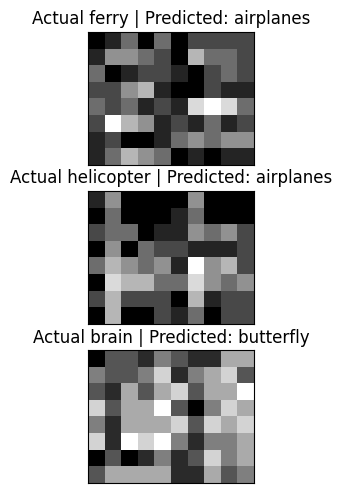

************************************************************
Support Vector Machines (SVMs) Classification.
Number of images incorrectly classified for SVM is: 116
Train Accuracy for SVM is: 1.0 
Test Accuracy for SVM is: 0.618421052631579


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6588459327290416
Recall: 0.618421052631579
F1-score: 0.6174005721558611
Top 3 Miss-Classified Classes.


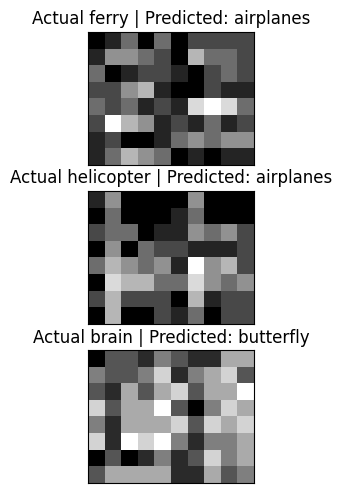

************************************************************
Random Forest Classifier.
Number of images incorrectly classified for Random Forest is: 145
Train Accuracy for Random Forest is: 1.0 
Test Accuracy for Random Forest is: 0.5230263157894737


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.48269502326897
Recall: 0.5230263157894737
F1-score: 0.46155906041909533
Top 3 Miss-Classified Classes.


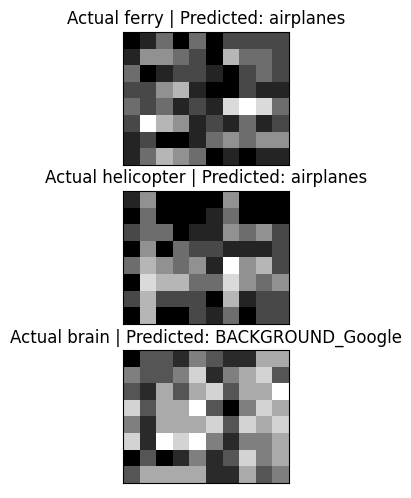

************************************************************
KNN Classifier.
Number of images incorrectly classified for KNN is: 140
Train Accuracy for KNN is: 1.0 
Test Accuracy for KNN is: 0.5394736842105263
Precision: 0.5405912005950706
Recall: 0.5394736842105263
F1-score: 0.5164836321636738
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


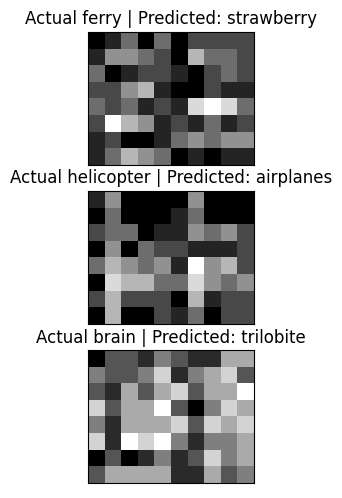

************************************************************
Logistic Regression Classifier.
Number of images incorrectly classified for Logistic Regression is: 128
Train Accuracy for Logistic Regression is: 0.6985294117647058 
Test Accuracy for Logistic Regression is: 0.5789473684210527
Precision: 0.5782792317331791
Recall: 0.5789473684210527
F1-score: 0.5625940569554025
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

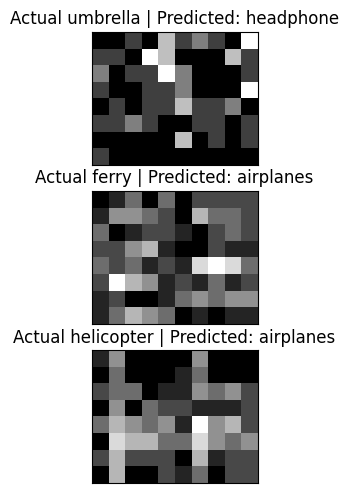

C:\Users\cecil\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


************************************************************
LGBM Classifier.
[LightGBM] [Warning] num_iterations is set=300, max_iter=300 will be ignored. Current value: num_iterations=300
Number of images incorrectly classified for LGBM is: 129
Train Accuracy for LGBM is: 1.0 
Test Accuracy for LGBM is: 0.5756578947368421


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5760103383458647
Recall: 0.5756578947368421
F1-score: 0.5573403343480475
Top 3 Miss-Classified Classes.


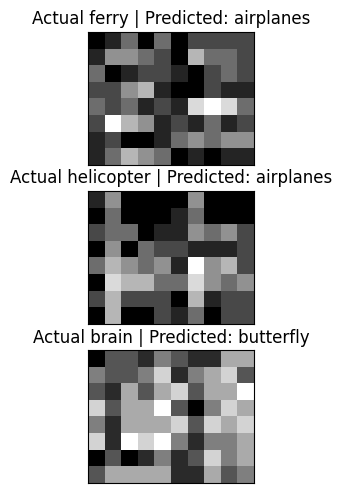

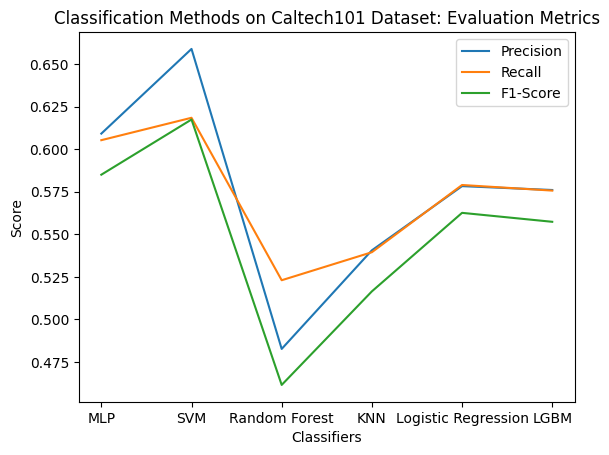

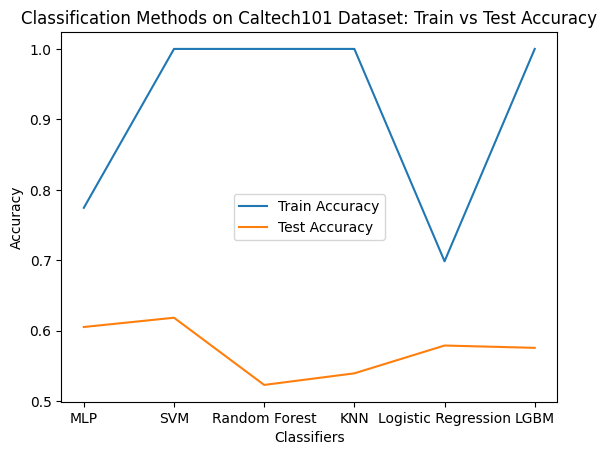

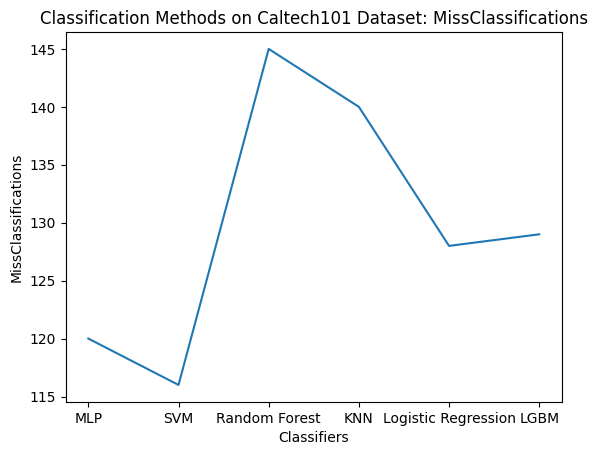

In [380]:
# Scenario 1: untouched Dataset with K-fold training Strategy on different classifiers.
# Select value 1.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(1)

using Stratified k-Fold Devision.
************************************************************
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8169683257918552 
Test Accuracy for MLP is: 0.555921052631579
Number of images incorrectly classified for MLP is: 135
Precision: 0.5034496581646926
Recall: 0.555921052631579
F1-score: 0.5180322072067605
Loss difference observed Between train/test: 0.34257024416305293
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


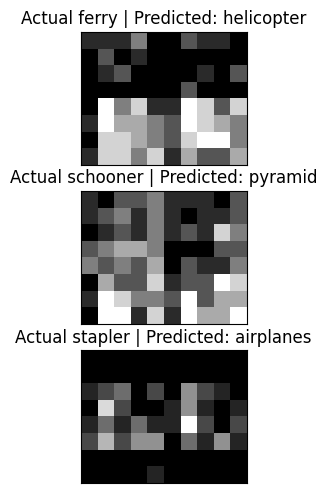

************************************************************
Support Vector Machines (SVMs) Classification.
Number of images incorrectly classified for SVM is: 133
Train Accuracy for SVM is: 1.0 
Test Accuracy for SVM is: 0.5625


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5378768671773703
Recall: 0.5625
F1-score: 0.5318883954319527
Top 3 Miss-Classified Classes.


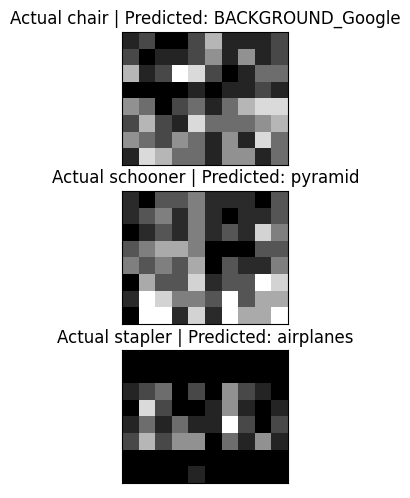

************************************************************
Random Forest Classifier.
Number of images incorrectly classified for Random Forest is: 155
Train Accuracy for Random Forest is: 1.0 
Test Accuracy for Random Forest is: 0.4901315789473684


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.41397594962500234
Recall: 0.4901315789473684
F1-score: 0.41343931726568167
Top 3 Miss-Classified Classes.


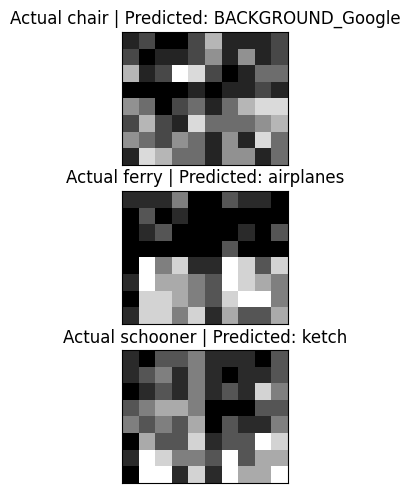

************************************************************
KNN Classifier.
Number of images incorrectly classified for KNN is: 155
Train Accuracy for KNN is: 1.0 
Test Accuracy for KNN is: 0.4901315789473684
Precision: 0.4481955222280301
Recall: 0.4901315789473684
F1-score: 0.4540264925133346
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


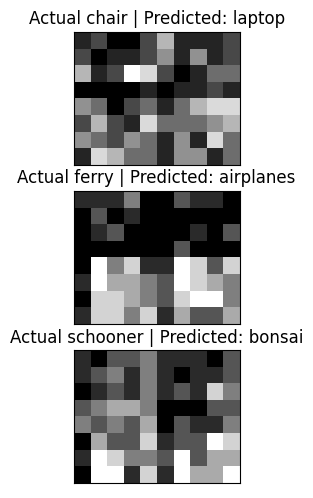

************************************************************
Logistic Regression Classifier.
Number of images incorrectly classified for Logistic Regression is: 146
Train Accuracy for Logistic Regression is: 0.6983031674208144 
Test Accuracy for Logistic Regression is: 0.5197368421052632
Precision: 0.45562761662679424
Recall: 0.5197368421052632
F1-score: 0.47238077423046687
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


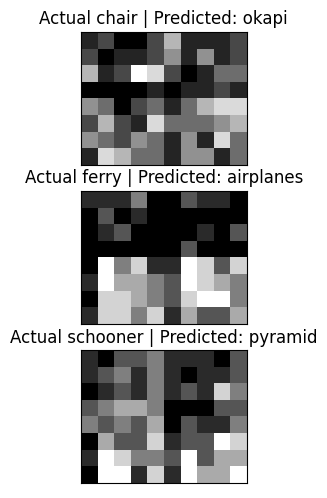

C:\Users\cecil\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


************************************************************
LGBM Classifier.
[LightGBM] [Warning] num_iterations is set=300, max_iter=300 will be ignored. Current value: num_iterations=300
Number of images incorrectly classified for LGBM is: 144
Train Accuracy for LGBM is: 1.0 
Test Accuracy for LGBM is: 0.5263157894736842


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.4752521457199032
Recall: 0.5263157894736842
F1-score: 0.48126321173391134
Top 3 Miss-Classified Classes.


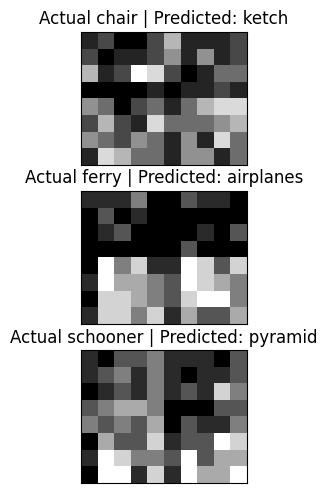

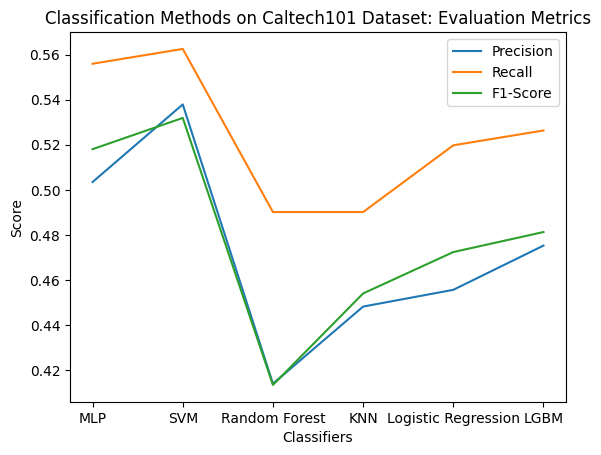

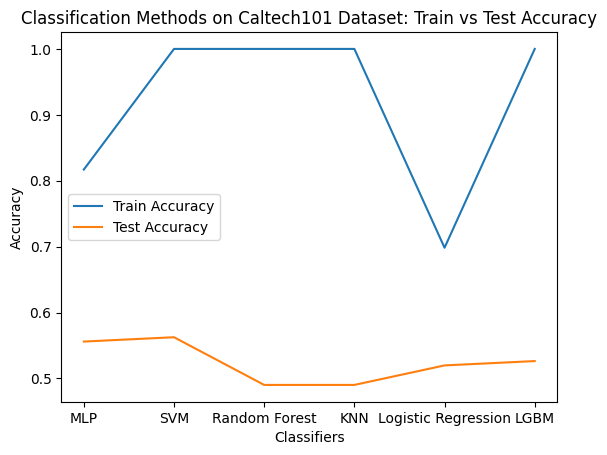

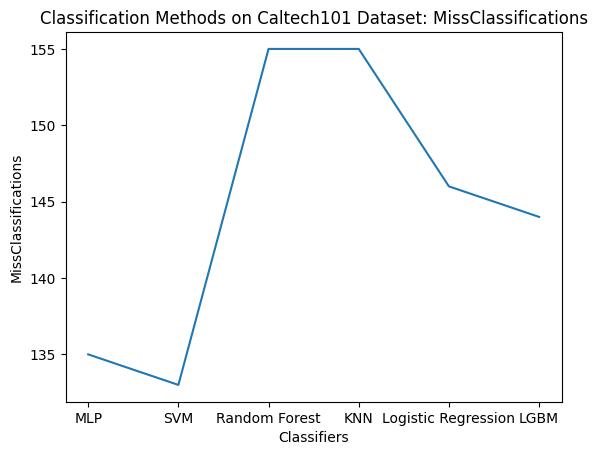

In [381]:
# Scenario 2: untouched Dataset with Stratified fold training Strategy on different classifiers.
# Select value 2.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(2)

Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
--------------------------------------------------------------------
Support Vector Machines (SVMs) Classification.
************************************************************
Trial with 3 number of images in classes
Number of images incorrectly classified for SVM is: 1712
Test Accuracy for SVM is: 0.2510936132983377
Precision for SVM is: 0.1981025722152886
Recall for SVM is: 0.195260371591728
F1 Score for SVM is: 0.17243921136922782
************************************************************
Trial with 5 number of images in classes
Number of images incorrectly classified for SVM is: 1469
Test Accuracy for SVM is: 0.3573928258967629
Precision for SVM is: 0.2536030914417445
Recall for SVM is: 0.26303391096379125
F1 Score for SVM is: 0.2350548400263995
************************************************************
Trial with 10 number of images in classes
Number of images incorrectly classified for SVM is: 1310
Test Ac

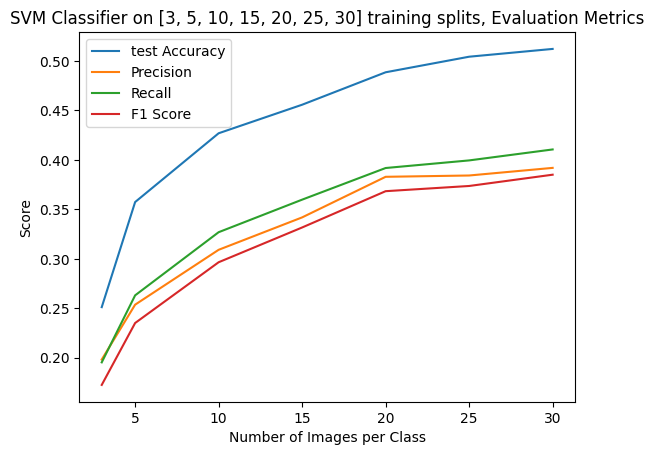

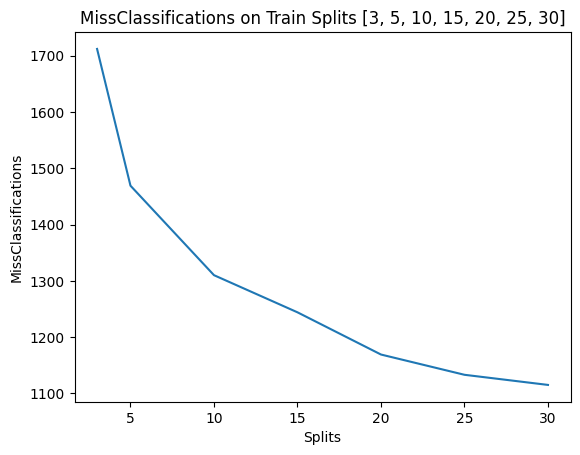

In [382]:
# Scenario 3: untouched Dataset with [3,5,10,15,20,25,30] Split training Strategy on SVM classifier.
# Select value 3.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(3)

In [388]:
# Performing Noise Class removal- Modifying the dataset
histogramData, image_classes=class_remove('BACKGROUND_Google',image_classes,histogramData)
nmrClassess=len(np.unique(image_classes))

using k-Fold Devision.
************************************************************
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8692179303767287 
Test Accuracy for MLP is: 0.5813148788927336
Number of images incorrectly classified for MLP is: 121
Precision: 0.6086640884727592
Recall: 0.5813148788927336
F1-score: 0.5688084847314057
Loss difference observed Between train/test: 0.5029264466437371
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


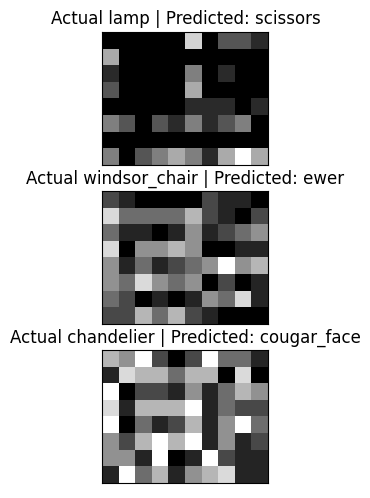

************************************************************
Support Vector Machines (SVMs) Classification.
Number of images incorrectly classified for SVM is: 107
Train Accuracy for SVM is: 1.0 
Test Accuracy for SVM is: 0.629757785467128


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6323143726181174
Recall: 0.629757785467128
F1-score: 0.6076264708264951
Top 3 Miss-Classified Classes.


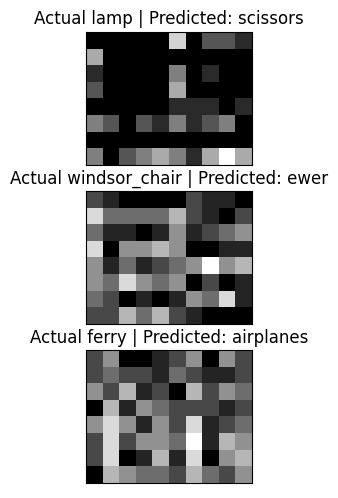

************************************************************
Random Forest Classifier.
Number of images incorrectly classified for Random Forest is: 136
Train Accuracy for Random Forest is: 1.0 
Test Accuracy for Random Forest is: 0.5294117647058824
Precision: 0.45437105457997273
Recall: 0.5294117647058824
F1-score: 0.4475774951935328
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


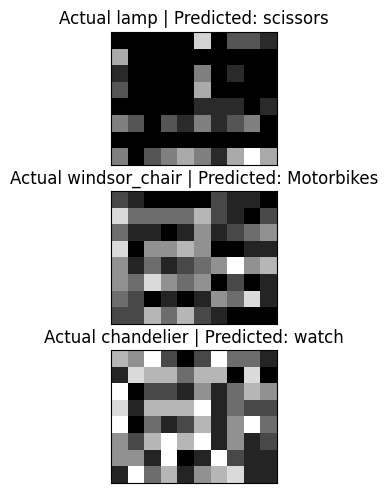

************************************************************
KNN Classifier.
Number of images incorrectly classified for KNN is: 130
Train Accuracy for KNN is: 1.0 
Test Accuracy for KNN is: 0.5501730103806228
Precision: 0.5326288225942205
Recall: 0.5501730103806228
F1-score: 0.523971815333026
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


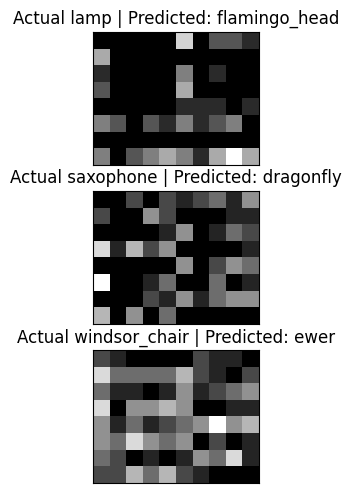

************************************************************
Logistic Regression Classifier.
Number of images incorrectly classified for Logistic Regression is: 120
Train Accuracy for Logistic Regression is: 0.734620886981402 
Test Accuracy for Logistic Regression is: 0.5847750865051903
Precision: 0.605525994995263
Recall: 0.5847750865051903
F1-score: 0.573551340161803
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

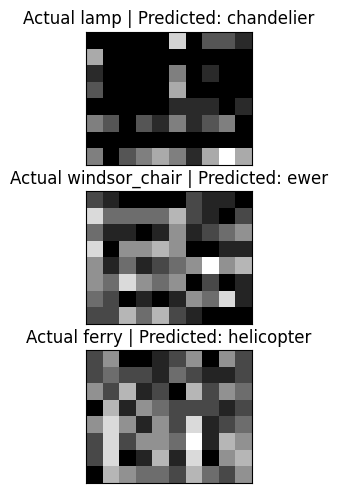

C:\Users\cecil\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


************************************************************
LGBM Classifier.
[LightGBM] [Warning] num_iterations is set=300, max_iter=300 will be ignored. Current value: num_iterations=300
Number of images incorrectly classified for LGBM is: 118
Train Accuracy for LGBM is: 1.0 
Test Accuracy for LGBM is: 0.5916955017301038


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5887458287255073
Recall: 0.5916955017301038
F1-score: 0.5718139233167737
Top 3 Miss-Classified Classes.


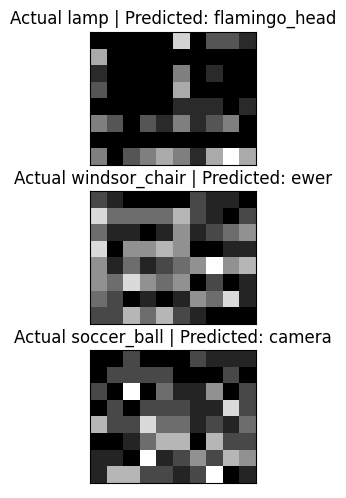

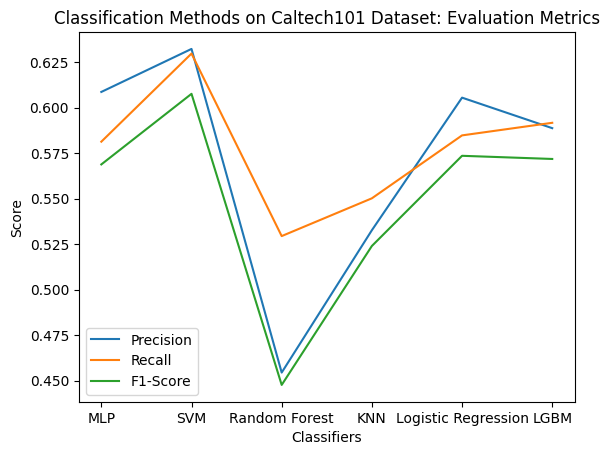

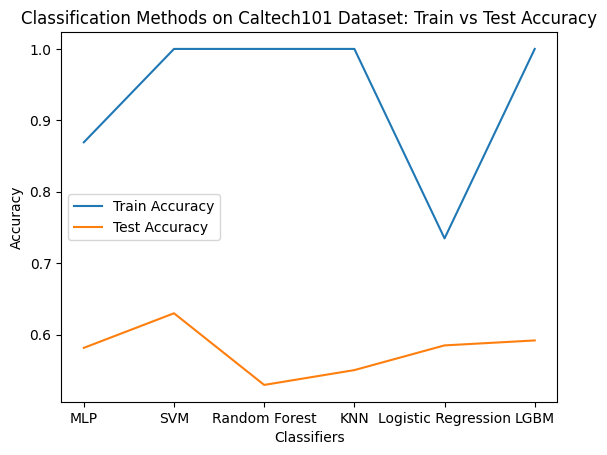

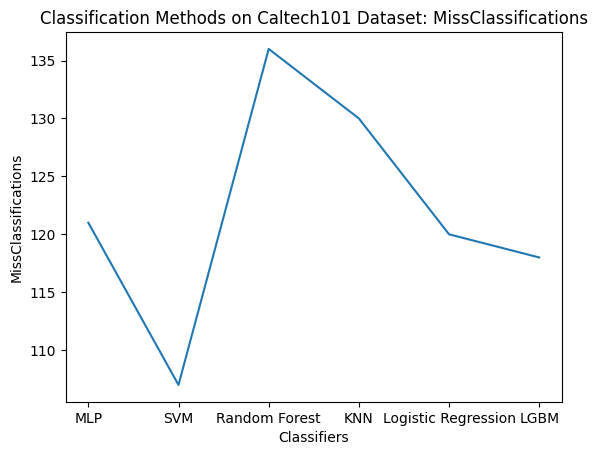

In [384]:
# Scenario 4: Modified Dataset with K-fold training Strategy on different classifiers.
# Select value 1.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(1)

using Stratified k-Fold Devision.
************************************************************
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8358369098712446 
Test Accuracy for MLP is: 0.6055363321799307
Number of images incorrectly classified for MLP is: 114
Precision: 0.5895882536020944
Recall: 0.6055363321799307
F1-score: 0.5766363833207347
Loss difference observed Between train/test: 0.16299480601130334
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


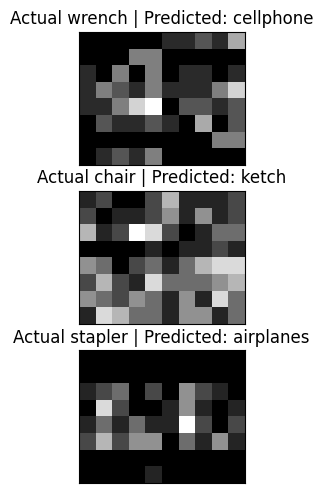

************************************************************
Support Vector Machines (SVMs) Classification.
Number of images incorrectly classified for SVM is: 92
Train Accuracy for SVM is: 1.0 
Test Accuracy for SVM is: 0.6816608996539792


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6815944227589616
Recall: 0.6816608996539792
F1-score: 0.658061199645271
Top 3 Miss-Classified Classes.


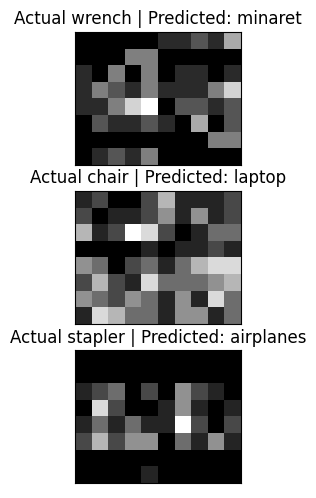

************************************************************
Random Forest Classifier.
Number of images incorrectly classified for Random Forest is: 132
Train Accuracy for Random Forest is: 1.0 
Test Accuracy for Random Forest is: 0.5432525951557093
Precision: 0.4205203065389052
Recall: 0.5432525951557093
F1-score: 0.4521149441420218
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


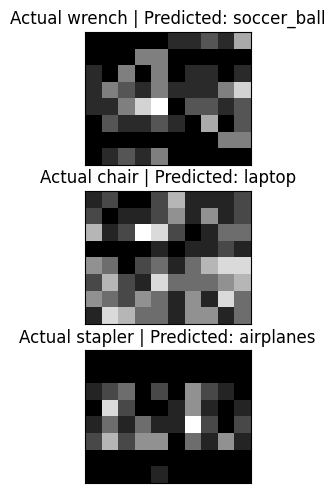

************************************************************
KNN Classifier.
Number of images incorrectly classified for KNN is: 125
Train Accuracy for KNN is: 1.0 
Test Accuracy for KNN is: 0.5674740484429066
Precision: 0.5306636998932948
Recall: 0.5674740484429066
F1-score: 0.5338852275236621
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


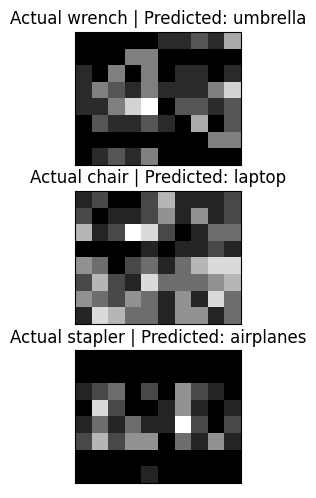

************************************************************
Logistic Regression Classifier.
Number of images incorrectly classified for Logistic Regression is: 110
Train Accuracy for Logistic Regression is: 0.7287792083929423 
Test Accuracy for Logistic Regression is: 0.6193771626297578
Precision: 0.5857505070993915
Recall: 0.6193771626297578
F1-score: 0.586912433674954
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


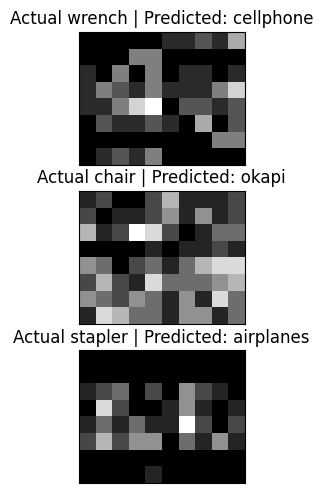

C:\Users\cecil\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


************************************************************
LGBM Classifier.
[LightGBM] [Warning] num_iterations is set=300, max_iter=300 will be ignored. Current value: num_iterations=300
Number of images incorrectly classified for LGBM is: 108
Train Accuracy for LGBM is: 1.0 
Test Accuracy for LGBM is: 0.6262975778546713


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6079672508545239
Recall: 0.6262975778546713
F1-score: 0.6003696938563619
Top 3 Miss-Classified Classes.


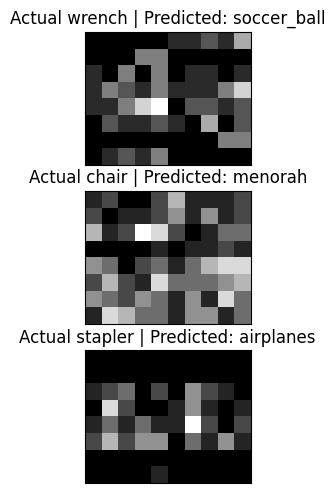

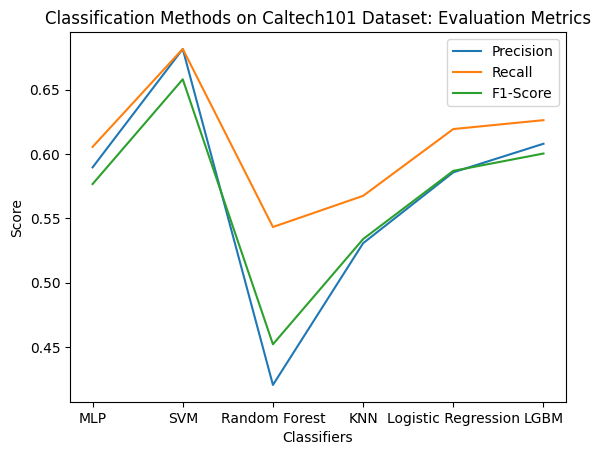

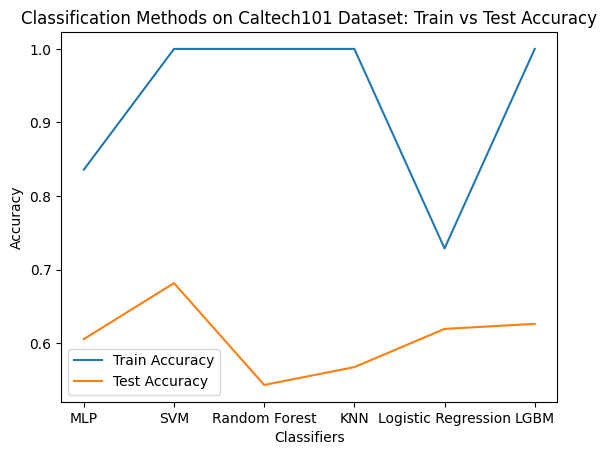

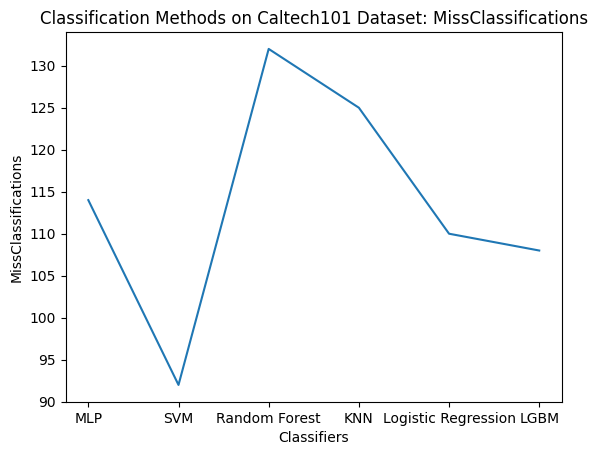

In [385]:
# Scenario 5: Modified Dataset with Stratified fold training Strategy on different classifiers.
# Select value 2.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(2)

Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
--------------------------------------------------------------------
Support Vector Machines (SVMs) Classification.
************************************************************
Trial with 3 number of images in classes
Number of images incorrectly classified for SVM is: 1482
Test Accuracy for SVM is: 0.3170506912442396
Precision for SVM is: 0.21413276102323187
Recall for SVM is: 0.21897844650049733
F1 Score for SVM is: 0.1951053502660097
************************************************************
Trial with 5 number of images in classes
Number of images incorrectly classified for SVM is: 1309
Test Accuracy for SVM is: 0.3967741935483871
Precision for SVM is: 0.27192017820491543
Recall for SVM is: 0.26581031399589256
F1 Score for SVM is: 0.2492665104236628
************************************************************
Trial with 10 number of images in classes
Number of images incorrectly classified for SVM is: 1168
Test

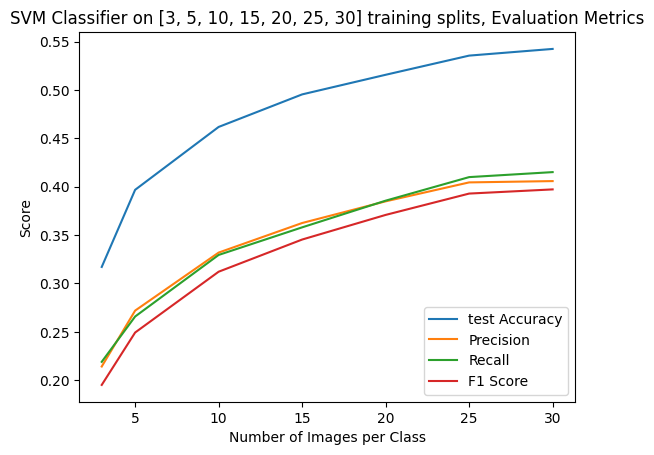

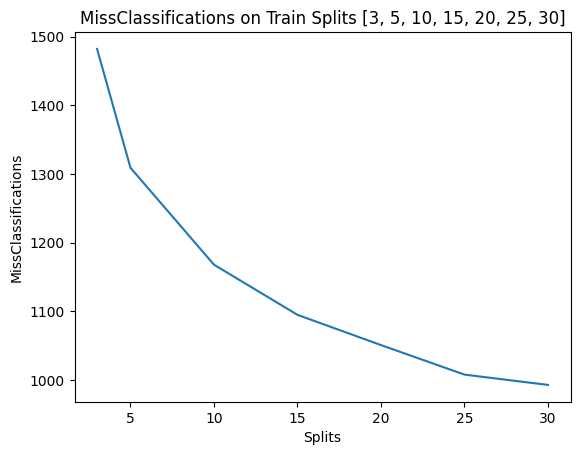

In [386]:
# Scenario 6: Modified Dataset with [3,5,10,15,20,25,30] Split training Strategy on SVM classifier.
# Select value 3.
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun(3)